In [1]:
#Important imports
import torch
from torch import nn as nn # for NN
from torch.utils.data import Dataset # class to create dataset class
from torch import optim # Optimizer
from torch.nn import functional as F # activation functions
import matplotlib.pyplot as plt # to plot a graph
import pandas as pd # py data analysis

#Choosing devise to be gpu if have one, else cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(DEVICE)

cuda


In [3]:
#Creaating DataSet class with which we will transform our tabelar data into tensors
class DataSet(Dataset):

    def __init__(self,path):  
        #transformed csv file into tensor
        self.dataset = torch.tensor(pd.read_csv(path).values)

    def __len__(self):
        #return lenght of dataset
        return len(self.dataset)

    def __getitem__(self, i):
        #returns X and Y data by index
        return self.dataset[i,:-1], self.dataset[i,-1]            ## mb add transformation that normalizes

In [4]:
class Net(nn.Module):

    def __init__(self, n_features):
        super().__init__()
        #Setting number of initial features, which will be equal to number of features in dataset
        self.n_features = n_features
        
        #self.norm = nn.LayerNorm(n_features)
        #Setting some layers for our architecture
        self.fc1 = nn.Linear(self.n_features,16) # (input, ouput)
        self.fc2 = nn.Linear(16,32) # (input, ouput)
        self.fc3 = nn.Linear(32,1)  # (input, ouput)           

    def forward(self,x):
        #Running forward cycle of our network
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.sigmoid(self.fc3(out))  
        
        #returning ouput
        return out

In [5]:
# Training loop for our network
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader, print_plot=True):

    #Initializing two lists to save accuracy to plot them later
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)

    #Going thru every epoch
    for epoch in range(n_epochs):

        #Going thru example, thru every batch, in our case, thru all data at once
        for example, labels in train_loader:     

            #Translating calculations to gpu if is available
            example = example.to(DEVICE)
            labels = labels.to(DEVICE)

            # ensuring equal number of dimensions for labels and examples
            labels  = labels.unsqueeze(1)

            # running our data thru our data - forward
            output = model(example.float())
            # Getting loss of our network right now
            loss = loss_fn(output, labels.float())

            # Zeroing the gradient to not stack it from other iterations
            optimizer.zero_grad()
            #Runing backward part of the neural network, getting gradiets
            loss.backward()
            #Updating our paramters
            optimizer.step()
            
            
        with torch.no_grad():
            
            for loader, accuracy in [(train_loader, train_accuracy),(test_loader, test_accuracy)]:
                correct = 0
                total = 0

                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples.float())
                    predicted = torch.round(outputs)

                    total += labels.shape[0]
                    correct += (predicted == labels).sum()

                accuracy[epoch] = correct / total

        if (epoch+1) % 10 ==0:
            print(f'Epoch {epoch+1})', 
                  f'Train Accuracy: {train_accuracy[epoch]}',
                  f'Test Accuracy: {test_accuracy[epoch]}')

    #If set to True, print graph of train and validation loss
    if print_plot:

        #Setting x-ticks
        epochs = range(n_epochs)

        #Ploting both curves, train and val 
        plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [6]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

#Creating Dataset from csv file
data = DataSet(r'D:\__python_works\_cvc_jy\diabetes.csv')

#Saving nr of examples and calculating number of validation samples
n_samples = len(data)
n_test = int(0.2*n_samples)

#Spliting into train and validation
train_set, test_set = torch.utils.data.random_split(data,  [n_samples-n_test, n_test])


# running train and validation sets thru dataloader that helps with parallelizing the data loading process with automatic batching
train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=len(test_set), shuffle=True)

c:\users\nicol\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10) Train Accuracy: 0.3544715344905853 Test Accuracy: 0.3464052379131317
Epoch 20) Train Accuracy: 0.6455284357070923 Test Accuracy: 0.6666666865348816
Epoch 30) Train Accuracy: 0.6585365533828735 Test Accuracy: 0.6666666865348816
Epoch 40) Train Accuracy: 0.6975609660148621 Test Accuracy: 0.7124183177947998
Epoch 50) Train Accuracy: 0.712195098400116 Test Accuracy: 0.6666666865348816
Epoch 60) Train Accuracy: 0.7333332896232605 Test Accuracy: 0.6993464231491089
Epoch 70) Train Accuracy: 0.7349593043327332 Test Accuracy: 0.6666666865348816
Epoch 80) Train Accuracy: 0.7252032160758972 Test Accuracy: 0.6993464231491089
Epoch 90) Train Accuracy: 0.7382113933563232 Test Accuracy: 0.6993464231491089
Epoch 100) Train Accuracy: 0.7414634227752686 Test Accuracy: 0.7058823704719543
Epoch 110) Train Accuracy: 0.7512195110321045 Test Accuracy: 0.6993464231491089
Epoch 120) Train Accuracy: 0.7479674816131592 Test Accuracy: 0.7058823704719543
Epoch 130) Train Accuracy: 0.7284552454948425 Test

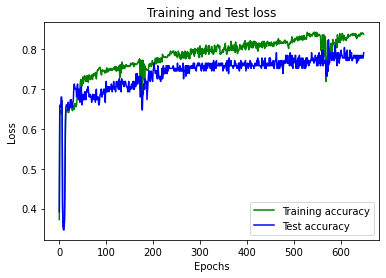

In [7]:
#Setting some hyperparameters and parameters
learning_rate = 1e-2 #0.01 

#Initializing model with nr of features from input
model = Net(len(data[0][0])).to(DEVICE)

#Optimizer and loss funtion
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

#Running training loop on the data with set parameters
training_loop(
    n_epochs=650,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)